Iteration: 0, Predators: 64, Prey: 136 (after death and reproduction)


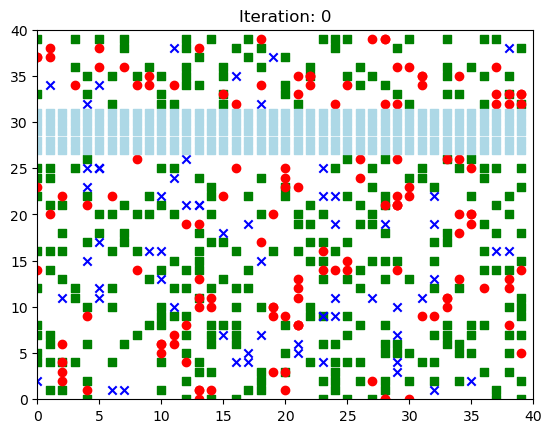

Iteration: 1, Predators: 48, Prey: 103 (after death and reproduction)


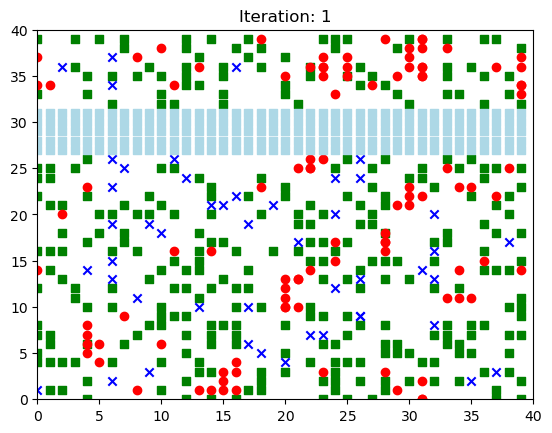

Iteration: 2, Predators: 41, Prey: 105 (after death and reproduction)


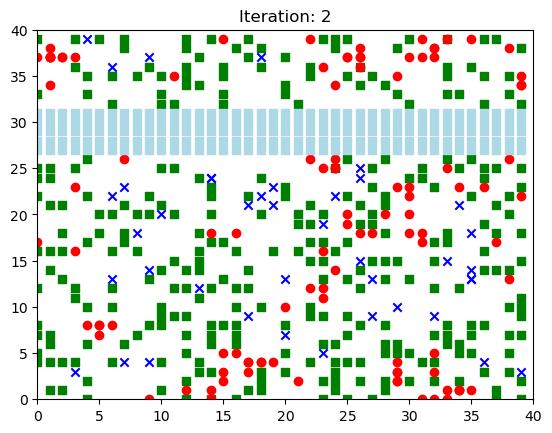

Iteration: 3, Predators: 36, Prey: 110 (after death and reproduction)


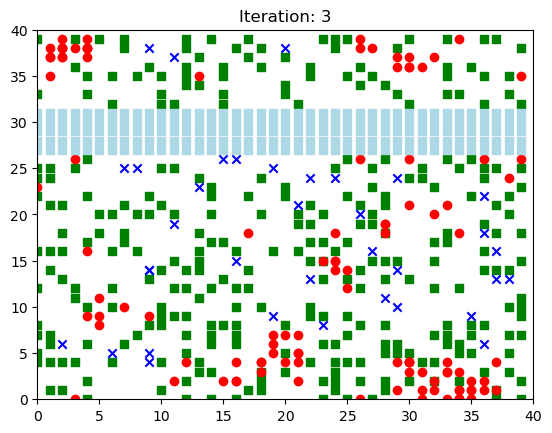

Iteration: 4, Predators: 25, Prey: 101 (after death and reproduction)


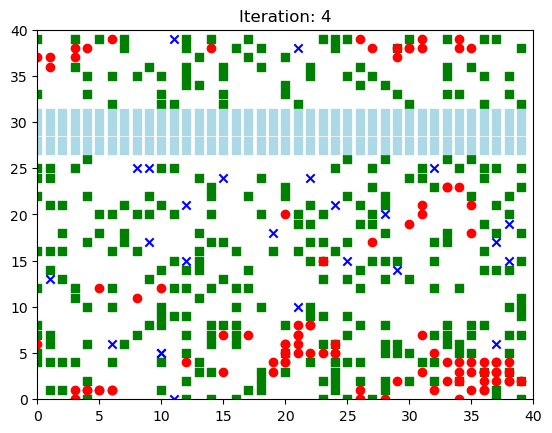

Iteration: 5, Predators: 18, Prey: 120 (after death and reproduction)


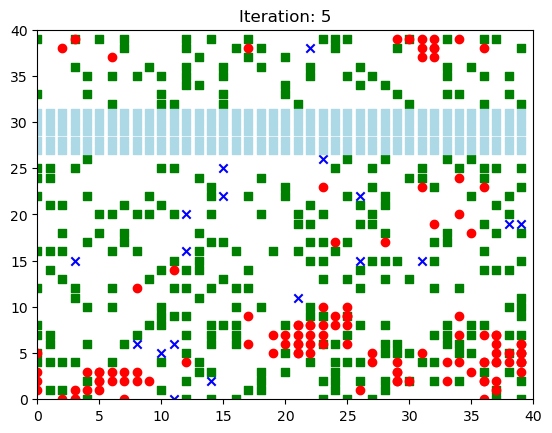

Iteration: 6, Predators: 18, Prey: 113 (after death and reproduction)


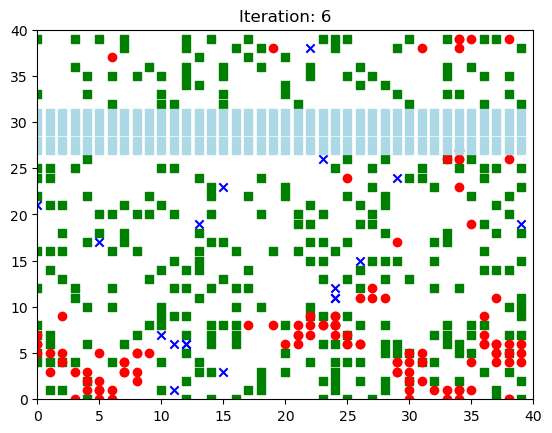

Iteration: 7, Predators: 13, Prey: 113 (after death and reproduction)


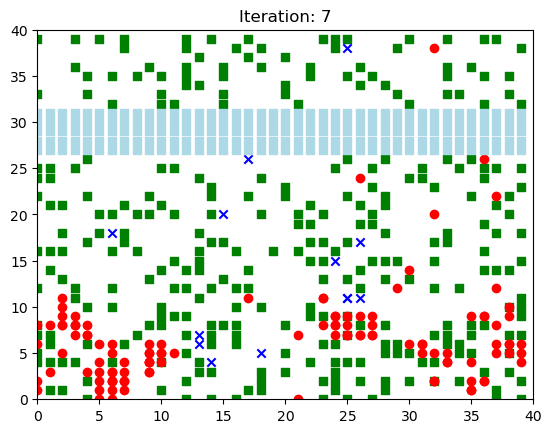

Iteration: 8, Predators: 13, Prey: 127 (after death and reproduction)


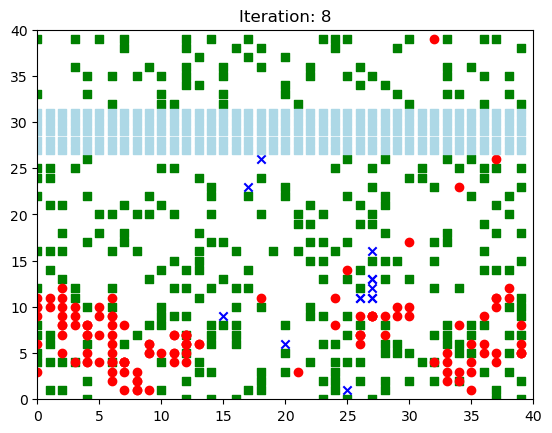

Iteration: 9, Predators: 13, Prey: 140 (after death and reproduction)


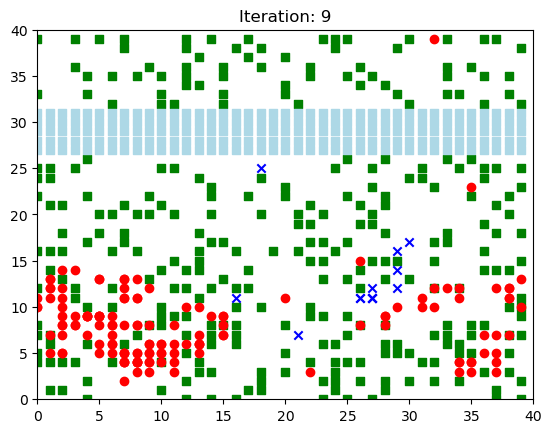

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size and initial populations
grid_size = 40
prey_population = 200
predator_population = 100
prey_birth_rate = 0.7
predator_death_rate = 0.01
predator_birth_rate = 0.5
prey_death_rate = 0.05  # Define prey death rate
min_prey_for_predator_reproduction = 3  # Adjust this parameter as needed

# Initialize the grid with zeros (empty cells) and add obstacles (trees)
grid = np.zeros((grid_size, grid_size))
obstacle_density = 0.2  # Adjust this parameter to control obstacle density
obstacle_positions = np.random.choice([0, 1], size=(grid_size, grid_size), p=[1 - obstacle_density, obstacle_density])
grid += obstacle_positions

# Add a winding river as an obstacle
river_width = 5
river_start = np.random.randint(0, grid_size - river_width)
for i in range(river_width):
    obstacle_positions[river_start + i, :] = 2  # Light blue for the river

# Randomly distribute prey and predators on the grid
prey_positions = np.random.choice(range(grid_size), size=(prey_population, 2), replace=True)
predator_positions = np.random.choice(range(grid_size), size=(predator_population, 2), replace=True)

# Set the values of prey and predator cells to 1 and 2, respectively
grid[prey_positions[:, 0], prey_positions[:, 1]] = 1
grid[predator_positions[:, 0], predator_positions[:, 1]] = 2

# Define movement directions (up, down, left, right)
directions = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])

def get_valid_positions_with_river_and_trees(current_positions, moves):
    global obstacle_positions

    new_positions = (current_positions + moves) % grid_size
    new_positions = new_positions.astype(int)

    # Check if the new positions are not in the river, on trees, or occupied by predators
    valid_positions = [
        pos for pos in new_positions
        if obstacle_positions[pos[0], pos[1]] != 1 and obstacle_positions[pos[0], pos[1]] != 2
    ]

    return np.array(valid_positions)


def update(iteration):
    global grid, prey_positions, predator_positions, obstacle_positions

    # Move prey if there are positions
    if len(prey_positions) > 0:
        prey_moves = np.random.choice(range(4), size=(len(prey_positions), 2))
        prey_positions = get_valid_positions_with_river_and_trees(prey_positions, prey_moves)

    # Move predators if there are positions
    if len(predator_positions) > 0:
        predator_moves = np.random.choice(range(4), size=(len(predator_positions), 2))
        predator_positions = get_valid_positions_with_river_and_trees(predator_positions, predator_moves)

    # Check if prey or predators are on obstacle positions and adjust their positions
    prey_positions = get_valid_positions_with_river_and_trees(prey_positions, np.zeros_like(prey_positions))
    predator_positions = get_valid_positions_with_river_and_trees(predator_positions, np.zeros_like(predator_positions))

    # Create a new grid
    new_grid = np.zeros((grid_size, grid_size))

    # Update grid based on new positions
    for pos in prey_positions:
        new_grid[pos[0], pos[1]] = 1

    for pos in predator_positions:
        new_grid[pos[0].astype(int), pos[1].astype(int)] = 2

    # Prey reproduction based on proximity to other prey and birth rate
    new_prey_positions = []
    for prey_pos in prey_positions:
        nearby_prey = prey_positions[np.linalg.norm(prey_positions - prey_pos, axis=1) < 2]
        if len(nearby_prey) > 1 and np.random.rand() < prey_birth_rate:
            random_direction_index = np.random.choice(len(directions))
            new_prey_positions.append(prey_pos + directions[random_direction_index])

    # Update grid based on new prey positions
    new_prey_positions = np.array(new_prey_positions) % grid_size
    new_prey_positions = new_prey_positions.reshape((-1, 2))  # Reshape to 2D array

    # Check if prey_positions is empty before concatenation
    if len(prey_positions) > 0:
        prey_positions = np.vstack([prey_positions, new_prey_positions])
    else:
        prey_positions = new_prey_positions

    # Predator reproduction based on minimum prey eaten, proximity to other predators, and birth rate
    new_predator_positions = []
    for predator_pos in predator_positions:
        nearby_prey = prey_positions[np.linalg.norm(prey_positions - predator_pos, axis=1) < 2]
        if len(nearby_prey) >= min_prey_for_predator_reproduction and np.random.rand() < predator_birth_rate:
            # Reproduce only if the number of nearby prey is above the threshold and with birth rate
            random_direction_index = np.random.choice(len(directions))
            new_predator_positions.append(predator_pos + directions[random_direction_index])

    # Check if new_predator_positions is not empty before further processing
    if new_predator_positions:
        new_predator_positions = np.array(new_predator_positions) % grid_size
        new_predator_positions = new_predator_positions.reshape((-1, 2))  # Reshape to 2D array

        # Check if predator_positions is empty before concatenation
        if len(predator_positions) > 0:
            predator_positions = np.vstack([predator_positions, new_predator_positions])
        else:
            predator_positions = new_predator_positions
            
    # Update grid based on new predator positions
    new_predator_positions = np.array(new_predator_positions) % grid_size
    new_predator_positions = new_predator_positions.reshape((-1, 2))  # Reshape to 2D array
    grid[new_predator_positions[:, 0].astype(int), new_predator_positions[:, 1].astype(int)] = 2
    predator_positions = np.vstack([predator_positions, new_predator_positions])

    # Remove prey based on predator proximity
    prey_to_remove = []
    for prey_pos in prey_positions:
        if len(predator_positions) > 0 and np.any(np.linalg.norm(predator_positions - prey_pos, axis=1) < 2):
            # Prey caught by a predator
            prey_to_remove.append(True)
        else:
            prey_to_remove.append(np.random.rand() < prey_death_rate)

    prey_positions = prey_positions[np.logical_not(prey_to_remove)]

    # Remove predators based on death rate
    predator_to_remove = np.random.rand(len(predator_positions)) < predator_death_rate
    predator_positions = predator_positions[~predator_to_remove]

    # Update the global grid
    grid = new_grid

    # Print the number of predators and prey after death and reproduction
    num_predators = len(predator_positions)
    num_prey = len(prey_positions)
    print(f"Iteration: {iteration}, Predators: {num_predators}, Prey: {num_prey} (after death and reproduction)")

def plot_grid(iteration):
    global prey_positions, predator_positions, grid_size, obstacle_positions

    plt.figure()

    # Plot trees as green squares
    tree_indices = np.argwhere(obstacle_positions == 1)
    if len(tree_indices) > 0:
        plt.scatter(tree_indices[:, 1], tree_indices[:, 0], c='green', marker='s', label='Trees')

    # Plot prey as red points
    if len(prey_positions) > 0:
        plt.scatter(prey_positions[:, 1], prey_positions[:, 0], c='red', marker='o', label='Prey')

    # Plot predators as blue points
    if len(predator_positions) > 0:
        plt.scatter(predator_positions[:, 1], predator_positions[:, 0], c='blue', marker='x', label='Predators')

    # Plot river as light blue squares
    river_indices = np.argwhere(obstacle_positions == 2)
    if len(river_indices) > 0:
        plt.scatter(river_indices[:, 1], river_indices[:, 0], c='lightblue', marker='s', label='River')

    plt.title(f"Iteration: {iteration}")
    #plt.grid(color='black', linestyle='-', linewidth=1)
    plt.xlim(0, grid_size)
    plt.ylim(0, grid_size)
    #plt.legend()
    plt.show()



# Run the simulation for a certain number of iterations
num_iterations = 10
for iteration in range(num_iterations):
    update(iteration)
    plot_grid(iteration)


In [7]:
!pip uninstall matplotlib
!pip install matplotlib


  Using cached matplotlib-3.8.3-cp39-cp39-win_amd64.whl (7.6 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\rkesh\\anaconda3\\anaconda 3\\Lib\\site-packages\\matplotlib\\_c_internal_utils.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

